# Analysis of 103k entries from the WOS

State of OA dataset

**Results are not 100% correct (some FB engagement numbers are missing) as some errors occured in the data collection**

Will be eventually updated if we run the fixed script again for this data.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from pprint import pprint

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})

plt.rcParams["figure.figsize"] = (9,5)

from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

In [104]:
full_df = pd.read_csv("PKP_temp.csv", encoding = 'utf8')
df_dates = pd.read_csv("data/input_files/PKP_20171220.csv", encoding = 'utf8')
full_df = full_df.merge(df_dates, on="doi").set_index("doi")
full_df['date'] = pd.to_datetime(full_df.date)
full_df['year'] = full_df.date.apply(lambda x: x.year)

# Table of Contents

## Bad rows (DOI resolve errors, URL-OG mapping errors)

ATM 25k rows are removed because of:

+ Remove bad urls (if resolved URL appears more than once in the results -> removed)
+ Remove entries with DOI resolve errors
+ Remove all entries with identical OG IDs
+ Exclude papers before 2008 and after 2015


## Some stats

**Frequencies**

Few stats for number of found articles across platform, years, and OA status

+ [Frequencies across years](#Frequencies-across-years)

**Shares**

Stats for the average number of shares across platform , years, and OA status.
Median numbers not included as they are quite boring (lots of 0 shares for FB, lots of 1 shares for Altmetric)

+ [Average shares across years](#Average-shares-across-years)

**Correlations**

+ [Correlation](#Correlation)

# Bad rows

In [62]:
print("The Bad Boyz\n")

# DOI resolving errors

resolve_errors = full_df[full_df.doi_resolve_status != "200"]
pprint(resolve_errors.doi_url.value_counts())
print("")

# Bad OG object mapping DOI -> URL -> OG

a = full_df.fb_og_id.value_counts().keys()[full_df.fb_og_id.value_counts() > 1][1:]
tdf = full_df[[x in a for x in full_df.fb_og_id]][["doi_url", "fb_og_id", "fb_share_count", "am_share_count"]]
pprint(tdf.describe().loc['count'])

# Export the "bad" DOIs as CSV files
# resolve_errors[['doi', 'url']].to_csv("recrawl_doi.csv", index=False)
# tdf[['doi', 'url']].to_csv("bad_urls.csv", index=False)

The Bad Boyz

None    84312
Name: doi_url, dtype: int64

fb_og_id          4855.0
fb_share_count    4855.0
am_share_count     626.0
Name: count, dtype: float64


Clean df and remove bad results :

In [101]:
# bad_resolves = list(full_df.doi_resolve_status != "200")
full_df = full_df[full_df['doi_resolve_status'] == 200]

#bad_urls = list(full_df.doi_url.value_counts().keys()[full_df.doi_url.value_counts() > 1])
#bad_url_papers = [x in bad_urls for x in full_df.doi_url]
full_df = full_df[full_df.duplicated(subset=['doi_url'])]

#bad_og_id = list(full_df.fb_og_id.value_counts().keys()[full_df.fb_og_id.value_counts() > 1])[1:]
#bad_og_papers = [x in bad_og_id for x in full_df.fb_og_id]
full_df = full_df[full_df.duplicated(subset=['fb_og_id'])]

min_year = 2010
max_year = 2018
# too_early = [x < min_year for x in full_df.year]
# too_late = [x > max_year for x in full_df.year]
full_df = full_df[full_df['year'].between(min_year, max_year)]

#bad_papers = list(np.any([bad_resolves, bad_url_papers, too_late, too_early, bad_og_papers], 0))


#df = full_df[[not _ for _ in bad_papers]]

print("Bad URLs: {}".format(sum(bad_url_papers)))
print("Bad OG IDs: {}".format(sum(bad_og_papers)))
print("Bad DOI resolves: {}".format(sum(bad_resolves)))
# print("Paper <2008: {}".format(sum(too_early)))
# print("Paper >2015: {}".format(sum(too_late)))

print("Total removed papers: {}".format(sum(bad_papers)))

Bad URLs: 96222
Bad OG IDs: 4855
Bad DOI resolves: 84312
Total removed papers: 156686


In [115]:
full_df[full_df.fb_og_id == 1420911837983045]

,timestamp,doi_resolve_status,doi_resolve_error,doi_url,fb_response_error,am_response_error,fb_og_id,fb_share_count,fb_reaction_count,fb_comment_plugin_count,fb_comment_count,am_id,am_score,am_share_count,date,url,year
doi,,,,,,,,,,,,,,,,,
10.3402/mehd.v20i4.7580,2017-12-14 15:55:49.422785,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-21,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v7i2.8160,2017-12-14 16:10:19.161577,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-14,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v9i6.8391,2017-12-14 16:49:11.057157,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-21,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v8i6.8316,2017-12-14 16:57:30.776987,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-21,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v10i2.7848,2017-12-14 16:58:40.986603,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-21,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v4i3.7652,2017-12-14 17:06:35.932119,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-04,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v3i3.7522,2017-12-14 17:18:22.563597,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-01,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v2i3.7459,2017-12-14 17:23:39.959211,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-01,http://www.microbecolhealthdis.net/index.php/m...,2011.0
10.3402/mehd.v17i4.7771,2017-12-14 17:24:55.686256,200,None,http://www.tandfonline.com/toc/zmeh20/current,None,404,1.420912e+15,4.0,1.0,0.0,0.0,NaN,NaN,NaN,2011-07-21,http://www.microbecolhealthdis.net/index.php/m...,2011.0


In [121]:
len(full_df)

287885

In [122]:
full_df.fb_og_id

doi
10.20983/noesis.2015.1.2                            1.211435e+15
10.20983/noesis.2015.1.2                            1.211435e+15
10.5195/jffp.2013.581                               1.132982e+15
10.7146/hjlcb.v7i12.25067                                    NaN
10.7146/math.scand.a-12293                                   NaN
10.14507/er.v0.1128                                          NaN
10.12804/apl33.02.2015.11                                    NaN
10.12804/apl33.02.2015.11                                    NaN
10.12681/makedonika.1099                                     NaN
10.5565/rev/dag.246                                          NaN
10.21746/ijbio.2013.03.0018                                  NaN
10.5565/rev/athenead/v1n3.72                                 NaN
10.5007/1984-8412.2017v14n1p1767                    1.245958e+15
10.21930/rcta.vol12_num1_art:214                             NaN
10.15150/lt.2003.1517                                        NaN
10.21009/0305020312  

In [120]:
full_df.duplicated(subset=['fb_og_id'], keep=False).sum()

263135

In [128]:
full_df.fb_og_id.isnull().sum()

257347

In [125]:
# bad_resolves = list(full_df.doi_resolve_status != "200")
df = full_df[full_df['doi_resolve_status'] == "200"]
print(len(df))

#bad_urls = list(full_df.doi_url.value_counts().keys()[full_df.doi_url.value_counts() > 1])
#bad_url_papers = [x in bad_urls for x in full_df.doi_url]
df = df[~df.duplicated(subset=['doi_url'], keep=False)]
print(len(df))

#bad_og_id = list(full_df.fb_og_id.value_counts().keys()[full_df.fb_og_id.value_counts() > 1])[1:]
#bad_og_papers = [x in bad_og_id for x in full_df.fb_og_id]
df = df[~df.fb_og_id.isnull() & ~df.duplicated(subset=['fb_og_id'], keep=False)]
print(len(df))

min_year = 2010
max_year = 2018
# too_early = [x < min_year for x in full_df.year]
# too_late = [x > max_year for x in full_df.year]
df = df[df['year'].between(min_year, max_year)]
print(len(df))

203573
191663
24751
17978


In [103]:
len(full_df)


0

## Preprocessing

Replace NaNs with 0.0 if either altmetric response or OG object was found, but on shares

,am_share_count,fb_share_count
doi,,
10.5195/jffp.2013.581,0.0,0.0
10.7146/hjlcb.v7i12.25067,0.0,0.0
10.5565/rev/dag.246,0.0,0.0
10.5565/rev/athenead/v1n3.72,0.0,0.0
10.5007/1984-8412.2017v14n1p1767,0.0,0.0
10.21930/rcta.vol12_num1_art:214,0.0,0.0
10.15150/lt.2003.1517,0.0,0.0
10.21009/0305020312,0.0,0.0
10.1590/S0080-62342005000400007,0.0,0.0


In [12]:
# Transformed dataframe for year/oa_color_long/platform plotting
pdf = df[['year', 'am_share_count', 'fb_share_count']].melt(id_vars = ['year'], var_name="platform", value_name="shares")
df[['year', 'am_share_count', 'fb_share_count']];

## Frequencies across years

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


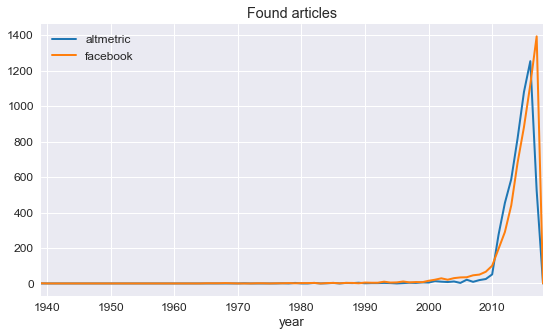

In [99]:
df['fb_share_count'] = df.fb_share_count.map(lambda x: np.nan if x == 0 else x)
df.groupby(['year'])[['am_share_count', 'fb_share_count']].count().plot();
# plt.xlim([min_year, max_year]);
plt.gca().legend(labels=["altmetric", "facebook"]);
plt.title("Found articles");

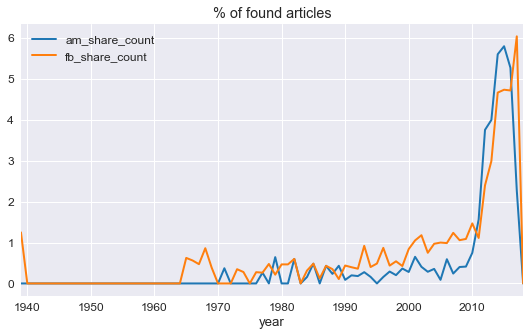

In [100]:
a = df.groupby(['year']).count()
(100*a[['am_share_count', 'fb_share_count']].divide(a.date,0)).plot();
plt.title("% of found articles");

In [96]:
df[['doi_url', 'am_share_count', 'fb_share_count']].dropna().describe()

,am_share_count,fb_share_count
count,1127.000000,1127.000000
mean,2.327418,2.530612
std,10.177125,8.228243
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,276.000000,136.000000


In [97]:
x = df[['doi_url', 'am_share_count', 'fb_share_count']].fillna(0)
d = x.fb_share_count -  x.am_share_count
print(len(d[d>0]))
print(len(d[d<0]))
print(len(d[d==0]))
print(len(d))

d.describe()

5201
4634
181786
191621


count    191621.000000
mean          0.033070
std           1.501437
min        -243.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         310.000000
dtype: float64

In [98]:
# FB > Altmetric
d[d>0].describe()

count    5201.000000
mean        2.739858
std         7.348221
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       310.000000
dtype: float64

In [87]:
# FB < AM
d[d<0].describe()

count    4613.000000
mean       -1.710384
std         4.629253
min      -243.000000
25%        -2.000000
50%        -1.000000
75%        -1.000000
max        -1.000000
dtype: float64

## Average shares across years

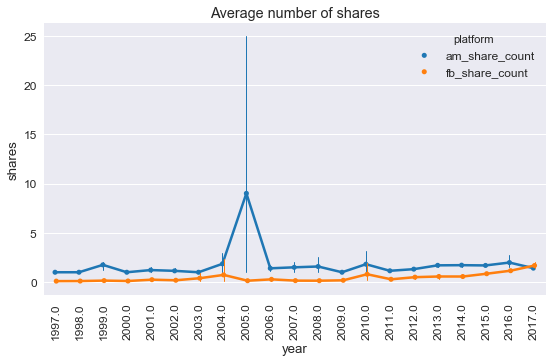

In [68]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");
plt.xticks(rotation=90);

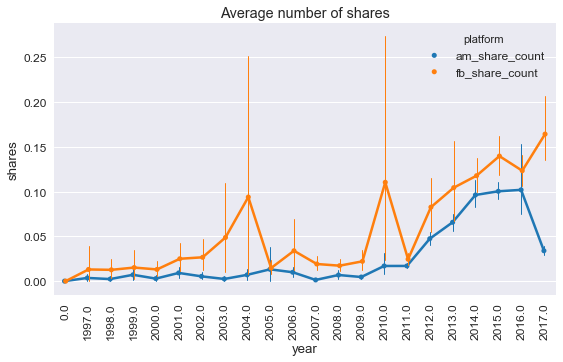

In [69]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf.fillna(0),
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");
plt.xticks(rotation=90);

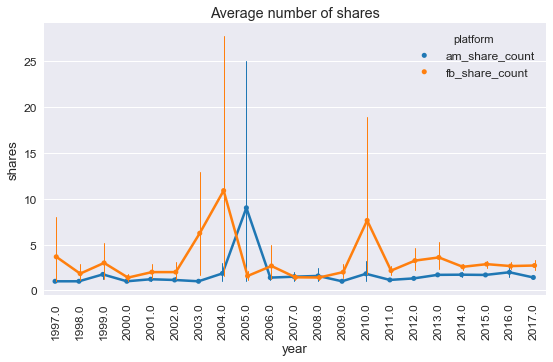

In [89]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf[pdf.shares != 0],
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares with rows dropped ");
plt.xticks(rotation=90);

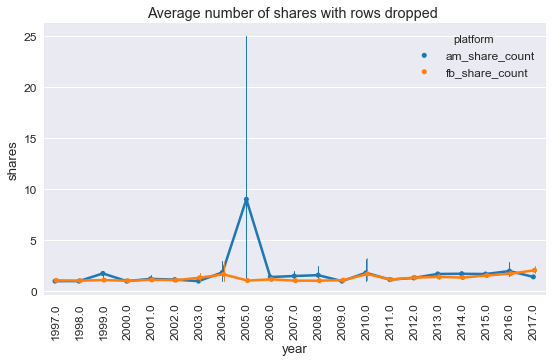

In [99]:
temp = pdf
temp.loc[pdf['shares'] == 0, 'shares'] = 1
sns.pointplot(x="year", y="shares", hue="platform", data=temp,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares with rows dropped ");
plt.xticks(rotation=90);

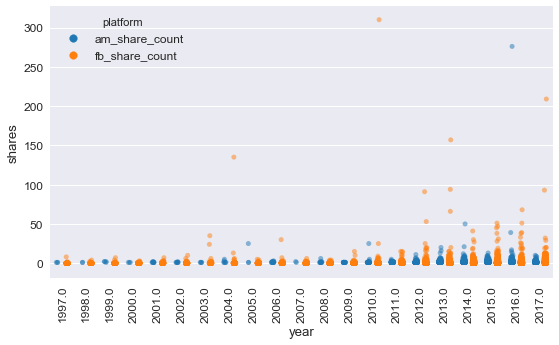

In [70]:
sns.stripplot(x="year", y="shares", hue="platform", data=pdf, jitter=True, dodge=True, alpha=.5);
plt.xticks(rotation=90);

## Correlation

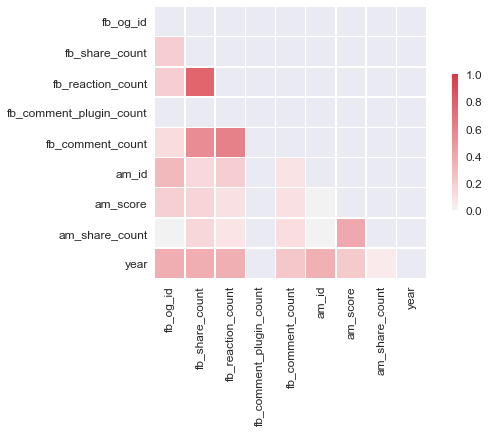

In [54]:
corr = df.corr(method = "spearman")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})